# Part 1: S&P 500 Stock Price Forecast
> **Motivation:** Beginning in March 2020 during the COVID pandemic, the stock market was turbulent. I want to know if it would have been possible to predict stock prices using RNNs.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import yfinance as yf
from scipy import stats

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import keras.backend as K
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.callbacks import EarlyStopping

## I) EDA

In [2]:
def candlestick(df, title, begin_year='1975'):
    # Plot candlestick chart
    temp = df[df.index > begin_year]
    fig = go.Figure(data=[go.Candlestick(x=temp.reset_index()['Date'],
                open=temp['Open'],
                high=temp['High'],
                low=temp['Low'],
                close=temp['Adj Close'])])
    
    fig.update_layout(title=title,
                      yaxis_title="USD")

    fig.show()

### Analyze the Stock Market
The S&P 500 Index is largely considered an essential benchmark of the stock market. I will analyze it to gain insight about the market

In [3]:
SP500 = yf.download('^GSPC')

[*********************100%***********************]  1 of 1 completed


Text(0.5, 1.0, 'S&P500: Summary')

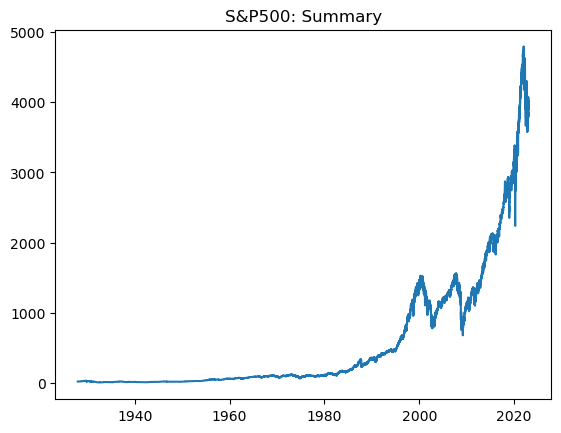

In [4]:
# Generic plot of S&P 500 stock price 
plt.plot(SP500['Adj Close'])
plt.title('S&P500: Summary')

In [5]:
def annual_percent_change(df):
    # Calculates percent annual return
    # Input: df[Date, Open, High, Low, Close, Adj Close]
    # Output: df[Year, Open, High, Low, Close, % Change]] 
    
    years = np.unique(np.array(SP500.index.year))[0:-1]
    percent_change = []
    year_open, year_close = [], [] 
    year_low, year_high = [], []

    for i in years:
        temp = df[(df.index >= str(i)) & (df.index < str(i+1))]['Adj Close']
        percent_change.append(round((temp[-1] / temp[0] - 1) * 100, 2))
        year_open.append(temp[0])
        year_close.append(temp[-1])
        year_low.append(min(temp))
        year_high.append(max(temp))
    
    result = pd.DataFrame({'Date':years, 
                         'Open': year_open,
                         'Close': year_close,
                         'Low': year_low,
                         'High': year_high,
                         '% Change': percent_change}).set_index('Date')
    return result 

SP500_YoY = annual_percent_change(SP500)

In [6]:
average_annual_return = np.mean(SP500_YoY[SP500_YoY.index >= 1950]['% Change'])

SP500_2019 = SP500_YoY[SP500_YoY.index == 2019]['% Change']
SP500_2020 = SP500_YoY[SP500_YoY.index == 2020]['% Change']
SP500_2021 = SP500_YoY[SP500_YoY.index == 2021]['% Change']

SP500_2019, SP500_2020, SP500_2021, average_annual_return

(Date
 2019    28.71
 Name: % Change, dtype: float64,
 Date
 2020    15.29
 Name: % Change, dtype: float64,
 Date
 2021    28.79
 Name: % Change, dtype: float64,
 8.894246575342464)

> The S&P500 index has delivered an average annual growth rate of 8.7% since 1950. However, this rule of thumb did not apply during the pandemic.
>* In 2019, S&P 500 grew  **29%**
>* In 2020, S&P 500 grew **15%**
>* In 2021, S&P 500 grew **29%** 

Text(0.5, 1.0, 'S&P500: % Annual Growth by Year')

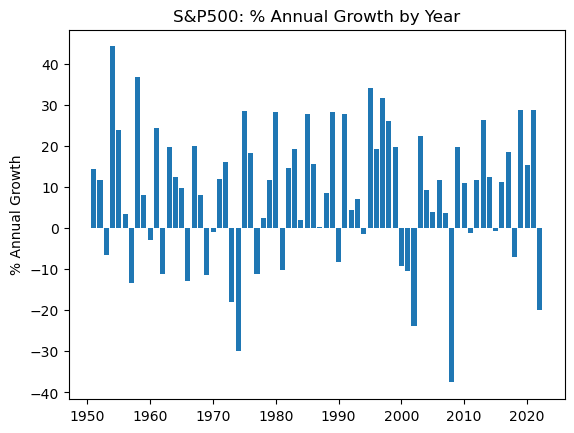

In [7]:
# Plot % Annual Growth
temp = SP500_YoY[SP500_YoY.index > 1950].reset_index() # Only include recent data, (1950 and beyond)
fig = plt.bar(x=temp["Date"], height=temp["% Change"])
plt.ylabel('% Annual Growth')
plt.title('S&P500: % Annual Growth by Year')

In [8]:
# Calculate percentile 
stats.percentileofscore(SP500_YoY['% Change'], SP500_2019), stats.percentileofscore(SP500_YoY['% Change'], SP500_2020), stats.percentileofscore(SP500_YoY['% Change'], SP500_2021)

(array([90.625]), array([64.58333333]), array([91.66666667]))

> The plot above shows the percent annual growth in price between 1950 and 2022. We occasionally see long positive streches, often followed by a big negative year. The 2019-2022 market is certainly bullish, with a growth rate in the **90th, 60th, and 90th percentile** which is reminiscent of the **dot-com bubble in the late 90s.**


## II) Modeling and Prediction
* **Objective**: Predict stock prices one day in advance. 

* Because future stock prices are very reliant on past prices, I will use the LSTM model which are a special kind of RNN, capable of learning long-term dependencies

### Preprocessing

In [9]:
def split(df, split_ratio):
    # Takes in a df and splits it into train and test df
    
    numrows_train = round(split_ratio * df.shape[0])
    train_df = df[0:numrows_train]
    test_df = df[numrows_train:]
    return train_df, test_df

In [10]:
df = SP500
split_ratio = 0.65

train_df, test_df = split(df, split_ratio)

In [11]:
def offset(array, n_features):
    # array: an array of normalized training or test data
    # n_features: use past n days of data as the feature to predict price
    # lookahead: how many days in the future you want to predict
        # Output: x_train and y_train
    x, y = [], []
    
    for i in range(n_features, len(array)-1):
        x.append(array[i-n_features:i])
        y.append(array[i, 0])

    return np.array(x), np.array(y)

In [12]:
scaler = MinMaxScaler(feature_range = (0,1))
n_features = 60 # Use the last 60 days as a feature

# Normalize training and test data
train_scaled = scaler.fit_transform(train_df['Adj Close'].values.reshape(-1,1))
test_scaled = scaler.fit_transform(test_df['Adj Close'].values.reshape(-1,1))

x_train, y_train = offset(train_scaled, n_features)
x_test, y_test = offset(test_scaled, n_features)

### Build model
Future stock prices are very reliant on past prices, so I will use an LSTM model that can draw dependencies from long past data.

In [13]:
def build_model():
    K.clear_session()
    model = Sequential()

    model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1],1)))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50))
    model.add(Dropout(0.2))

    model.add(Dense(units=1))
    
    return model

In [14]:
model = build_model()
model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1)

### Train model

In [15]:
model = build_model()
model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(x_train, y_train, epochs=12, 
          batch_size = 32)

Epoch 1/12
484/484 [==============================] - 14s 23ms/step - loss: 0.0018
Epoch 2/12
484/484 [==============================] - 11s 23ms/step - loss: 6.5765e-04
Epoch 3/12
484/484 [==============================] - 11s 22ms/step - loss: 5.7239e-04
Epoch 4/12
484/484 [==============================] - 11s 22ms/step - loss: 5.0790e-04
Epoch 5/12
484/484 [==============================] - 11s 22ms/step - loss: 4.4659e-04
Epoch 6/12
484/484 [==============================] - 11s 22ms/step - loss: 4.2951e-04
Epoch 7/12
484/484 [==============================] - 11s 22ms/step - loss: 3.9698e-04
Epoch 8/12
484/484 [==============================] - 11s 22ms/step - loss: 4.0245e-04
Epoch 9/12
484/484 [==============================] - 11s 22ms/step - loss: 4.0502e-04
Epoch 10/12
484/484 [==============================] - 11s 22ms/step - loss: 3.8175e-04
Epoch 11/12
484/484 [==============================] - 11s 23ms/step - loss: 3.7751e-04
Epoch 12/12
484/484 [========================

### Predict

In [16]:
test_pred = model.predict(x_test)
test_pred = scaler.inverse_transform(test_pred)

260/260 [==============================] - 3s 8ms/step


In [17]:
model.evaluate(x_test, y_test)

260/260 [==============================] - 3s 8ms/step - loss: 3.3080e-04


0.0003307992301415652

In [18]:
summary_df = test_df[n_features-6:-7].reset_index()
summary_df['Forecasted'] = test_pred

### Analysis

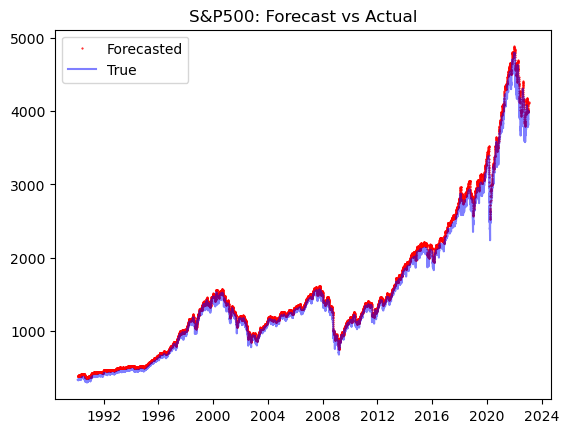

In [19]:
temp = summary_df.set_index('Date')
plt.plot(temp['Forecasted'],  'r.', markersize = 1, label='Forecasted')
plt.plot(temp['Adj Close'],  'b-', alpha=0.5, label='True')
plt.title('S&P500: Forecast vs Actual')
plt.legend()
plt.show()

The plot tells us that the forecasted price (blue) and true price (red) is overlapped. There are small deviations on a day-to-day basis once you zoom in, but the **model is proficient at predicting general market trends.**

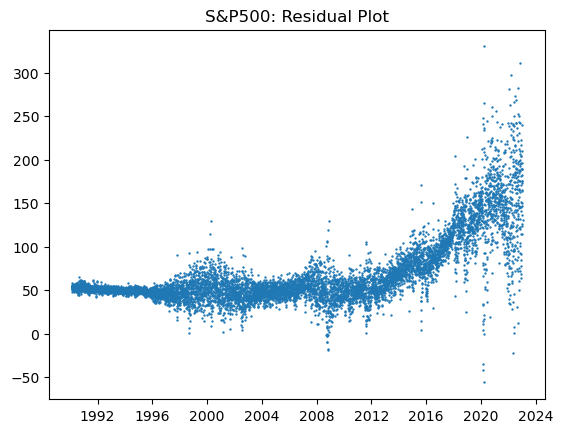

In [20]:
# Residual Plot
summary_df['Residual'] = summary_df['Forecasted'] - summary_df['Adj Close']
plt.scatter(summary_df['Date'], summary_df['Residual'], s=0.5)
plt.title('S&P500: Residual Plot')
plt.show()

In [43]:
# RMSE
summary_df['Squared Loss'] = (summary_df['Forecasted'] - summary_df['Adj Close'])**2
RMSE = np.sqrt(summary_df['Squared Loss'][summary_df['Date']>='2020'].mean())

In [22]:
# Top ten Losses
summary_df.sort_values('Squared Loss', ascending=False)[0:10]

,Date,Open,High,Low,Close,Adj Close,Volume,Forecasted,Residual,Squared Loss
7587,2020-03-23,2290.709961,2300.729980,2191.860107,2237.399902,2237.399902,7411380000,2567.320068,329.920166,108847.315944
8252,2022-11-09,3810.939941,3818.199951,3744.219971,3748.570068,3748.570068,4645010000,4059.208008,310.637939,96495.929428
8085,2022-03-14,4202.750000,4247.569824,4161.720215,4173.109863,4173.109863,5574920000,4470.189941,297.080078,88256.572819
8224,2022-09-30,3633.479980,3671.439941,3584.129883,3585.620117,3585.620117,5645360000,3867.292236,281.672119,79339.182701
8054,2022-01-27,4380.580078,4428.740234,4309.500000,4326.509766,4326.509766,5214200000,4607.057129,280.547363,78706.823044
8152,2022-06-17,3665.899902,3707.709961,3636.870117,3674.840088,3674.840088,8520740000,3947.740479,272.900391,74474.623203
8177,2022-07-26,3953.219971,3953.219971,3910.739990,3921.050049,3921.050049,3778950000,4190.062988,269.012939,72367.961593
8151,2022-06-16,3728.179932,3728.179932,3639.770020,3666.770020,3666.770020,5644930000,3933.049561,266.279541,70904.793963
7596,2020-04-03,2514.919922,2538.179932,2459.959961,2488.649902,2488.649902,6096970000,2753.638916,264.989014,70219.177367
8072,2022-02-23,4324.930176,4341.509766,4221.509766,4225.500000,4225.500000,4797430000,4488.451660,262.951660,69143.575579


**Thoughts**
* The above scatterplot is the residual plot of our model. Notice that the model has high loss everytime there is unexpected economic activity (like in the late 90s and 2009s). However, the model unequivocally had the **highest loss during lockdown**. In fact, the table shows that the **ten highest model loss occured during lockdown** 
* Although the model still remains a good estimate of the market, it appears it **overestimated the value of the index** which led to higher loss. 


**Other notes**
* When we used an 80:20 train-test split, the results were slightly better than 65:35. It might be because the training data learned from the dot-com bubble and was better equipped to predict the pandemic market.

# Part 2) Tech Stocks

I want to see how the model would perform for the tech sector specifically, seeing how growth in the tech sector was even more pronounced during the pandemic. NASDAQ 100 Technology Sector (NDXT) is an index composed of tech companies like Alphabet, Apple, and Meta (Facebook). 

In [23]:
df = yf.download('^NDXT')

[*********************100%***********************]  1 of 1 completed


In [24]:
split_ratio = 0.6
train_df, test_df = split(df, split_ratio)
scaler = MinMaxScaler(feature_range = (0,1))

In [25]:
n_features = 60

# Normalize training and test data
train_scaled = scaler.fit_transform(train_df['Adj Close'].values.reshape(-1,1))
test_scaled = scaler.fit_transform(test_df['Adj Close'].values.reshape(-1,1))

x_train, y_train = offset(train_scaled, n_features)
x_test, y_test = offset(test_scaled, n_features)

In [26]:
model = build_model()
model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(x_train, y_train, epochs=12, 
          batch_size = 32)

Epoch 1/12
78/78 [==============================] - 5s 23ms/step - loss: 0.0147
Epoch 2/12
78/78 [==============================] - 2s 23ms/step - loss: 0.0037
Epoch 3/12
78/78 [==============================] - 2s 22ms/step - loss: 0.0034
Epoch 4/12
78/78 [==============================] - 2s 22ms/step - loss: 0.0031
Epoch 5/12
78/78 [==============================] - 2s 23ms/step - loss: 0.0028
Epoch 6/12
78/78 [==============================] - 2s 23ms/step - loss: 0.0030
Epoch 7/12
78/78 [==============================] - 2s 23ms/step - loss: 0.0026
Epoch 8/12
78/78 [==============================] - 2s 23ms/step - loss: 0.0028
Epoch 9/12
78/78 [==============================] - 2s 22ms/step - loss: 0.0023
Epoch 10/12
78/78 [==============================] - 2s 23ms/step - loss: 0.0024
Epoch 11/12
78/78 [==============================] - 2s 23ms/step - loss: 0.0022
Epoch 12/12
78/78 [==============================] - 2s 23ms/step - loss: 0.0021


In [27]:
test_pred = model.predict(x_test)
test_pred = scaler.inverse_transform(test_pred)

52/52 [==============================] - 1s 8ms/step


In [28]:
model.evaluate(x_test, y_test)

52/52 [==============================] - 1s 8ms/step - loss: 0.0011


0.001065809279680252

In [29]:
summary_df = test_df[n_features-6:-7].reset_index()
summary_df['Forecasted'] = test_pred

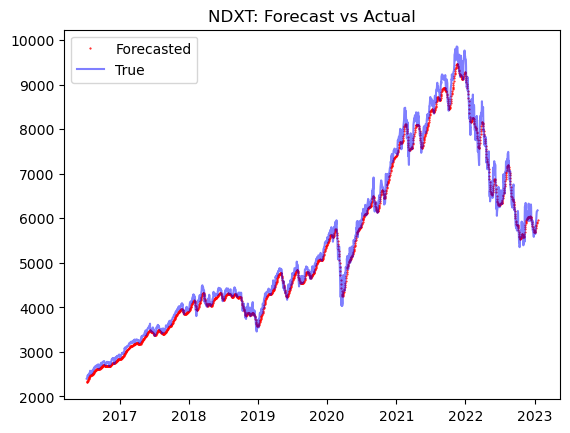

In [30]:
temp = summary_df.set_index('Date')
plt.plot(temp['Forecasted'],  'r.', markersize = 1, label='Forecasted')
plt.plot(temp['Adj Close'],  'b-', alpha=0.5, label='True')
plt.title('NDXT: Forecast vs Actual')
plt.legend()
plt.show()

> Like before, the model is **great at predicting the overall direction of the market.**

In [31]:
# RMSE
summary_df['Squared Loss'] = (summary_df['Forecasted'] - summary_df['Adj Close'])**2
RMSE = np.sqrt(summary_df[summary_df['Date']>'2020']['Squared Loss'].mean())
RMSE

198.52677787900717

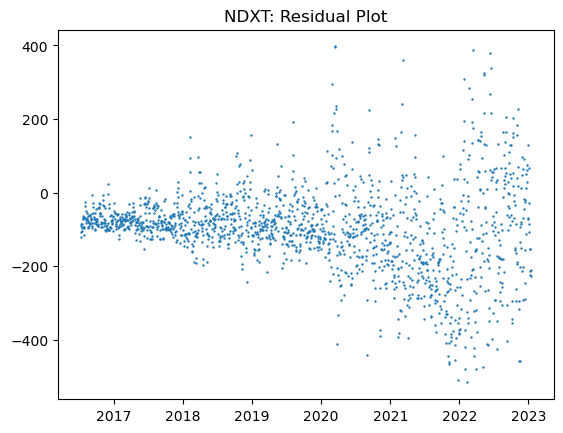

In [32]:
# Residual Plot
summary_df['Residual'] = summary_df['Forecasted'] - summary_df['Adj Close']
plt.scatter(summary_df['Date'], summary_df['Residual'], s=0.5)
plt.title('NDXT: Residual Plot')
plt.show()

>  We see the same pattern we saw for S&P500, except this time **it underestimated stock values instead of overvaluing it.** This outcome was somewhat expected, because the tech sector saw even more growth than S&P500 during this time.

# Part 3) Apple (AAPL)
AAPL was one of many stocks that showed outstanding growth even among the tech sector.

In [44]:
df = yf.download('AAPL')

[*********************100%***********************]  1 of 1 completed


In [45]:
split_ratio = 0.65
train_df, test_df = split(df, split_ratio)
scaler = MinMaxScaler(feature_range = (0,1))

In [46]:
n_features = 60

# Normalize training and test data
train_scaled = scaler.fit_transform(train_df['Adj Close'].values.reshape(-1,1))
test_scaled = scaler.fit_transform(test_df['Adj Close'].values.reshape(-1,1))

x_train, y_train = offset(train_scaled, n_features)
x_test, y_test = offset(test_scaled, n_features)

In [48]:
model = build_model()
model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(x_train, y_train, epochs=12, 
          batch_size = 32)

Epoch 1/12
214/214 [==============================] - 8s 22ms/step - loss: 0.0012
Epoch 2/12
214/214 [==============================] - 5s 22ms/step - loss: 6.1985e-04
Epoch 3/12
214/214 [==============================] - 5s 22ms/step - loss: 9.2886e-04
Epoch 4/12
214/214 [==============================] - 5s 22ms/step - loss: 4.2164e-04
Epoch 5/12
214/214 [==============================] - 5s 22ms/step - loss: 5.6967e-04
Epoch 6/12
214/214 [==============================] - 5s 22ms/step - loss: 4.3461e-04
Epoch 7/12
214/214 [==============================] - 5s 22ms/step - loss: 4.3261e-04
Epoch 8/12
214/214 [==============================] - 5s 22ms/step - loss: 3.6900e-04
Epoch 9/12
214/214 [==============================] - 5s 22ms/step - loss: 4.1891e-04
Epoch 10/12
214/214 [==============================] - 5s 22ms/step - loss: 3.9697e-04
Epoch 11/12
214/214 [==============================] - 5s 22ms/step - loss: 3.6410e-04
Epoch 12/12
214/214 [==============================] - 5

In [49]:
test_pred = model.predict(x_test)
test_pred = scaler.inverse_transform(test_pred)

115/115 [==============================] - 1s 8ms/step


In [50]:
model.evaluate(x_test, y_test)

115/115 [==============================] - 1s 8ms/step - loss: 9.6855e-04


0.0009685484110377729

In [51]:
summary_df = test_df[n_features-6:-7].reset_index()
summary_df['Forecasted'] = test_pred

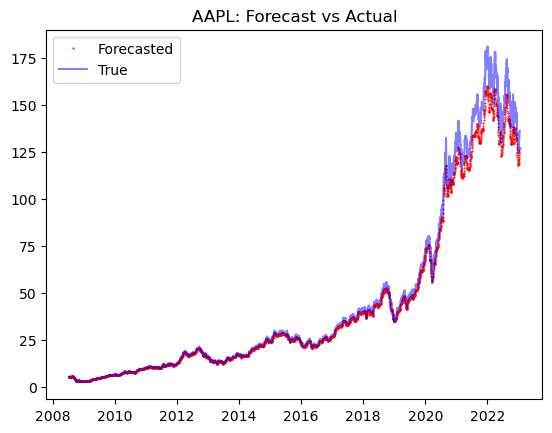

In [52]:
temp = summary_df.set_index('Date')
plt.plot(temp['Forecasted'],  'r.', markersize = 1, label='Forecasted')
plt.plot(temp['Adj Close'],  'b-', alpha=0.5, label='True')
plt.title('AAPL: Forecast vs Actual')
plt.legend()
plt.show()

> It appears like the model underestimated the stock values during the pandemic, but was still able to accurately forecast the stock movement.

In [53]:
summary_df['Squared Loss'] = (summary_df['Forecasted'] - summary_df['Adj Close'])**2
RMSE = np.sqrt(summary_df[summary_df['Date']>'2020']['Squared Loss'].mean())

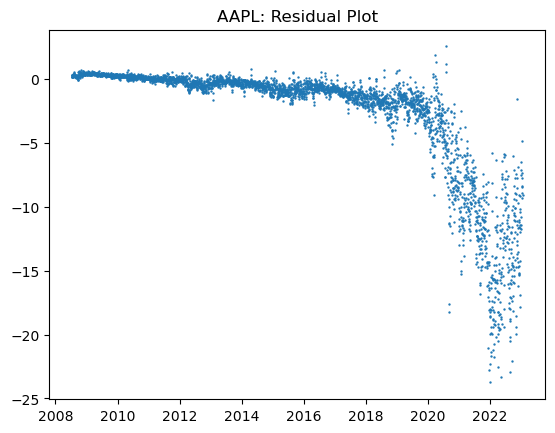

In [54]:
# Residual Plot
summary_df['Residual'] = summary_df['Forecasted'] - summary_df['Adj Close']
plt.scatter(summary_df['Date'], summary_df['Residual'], s=0.5)
plt.title('AAPL: Residual Plot')
plt.show()

> The model sharply underestimated AAPL stocks. Again, this was expected seeing how AAPL stocks tripled in value during this time, which was unprecedented. 

# Conclusion
During normal times, the model was a fantastic indicator of the market, with very little loss and predicting market trends accurately. The same can be said during the pandemic as the model was able to trace stock and index movement with surprising accuracy. However, it is vital to realize the inflated losses between 2020 to present, and account for the risk of relying too  heavily on machine learning to predict the inherent unpredictability in the stock market during such unprecedented times.